In [1]:
from rec.modules.snis_distribution import SNISDistribution

import tensorflow as tf
tfl = tf.keras.layers

import tensorflow_probability as tfp
tfd = tfp.distributions

import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Mixture of Gaussians

In [2]:
component_means = np.array([[-1, -1],
                            [-1, 0],
                            [-1, 1],
                            [0, -1],
                            [0, 0],
                            [0, 1],
                            [1, -1],
                            [1, 0],
                            [1, 1]], dtype=np.float32)
component_stds = 0.1

components = [tfd.Normal(loc=loc, scale=component_stds) for loc in component_means]

mixture = tfd.Mixture(cat=tfd.Categorical(probs=[[1 / 9] * 9] * 2),
                      components=components)

The log-likelihood of the importance sampler can be lower-bounded by

$$
\log p_{SNIS}(x) \geq \mathbb{E}_{x_{2:K}} \log \left[ \frac{\pi(x)w(x)}{\frac{1}{K}\left( \sum_{j=2}^K w(x_j) + w(x) \right)} \right ]
$$

The lower bound is equal to

$$
\mathbb{E}_{x_{2:K}}\left[ \log\pi(x) + \underbrace{U(x)}_{\log w(x)} + \log K - \log \left\{\sum_{j = 2}^K w(x_j) + w(x) \right\}\right]
$$

In [8]:
class SNISNetwork(tfl.Layer):
    
    def __init__(self, hidden=20, activation="tanh", name="snis_network", **kwargs):
        
        super(SNISNetwork, self).__init__(name=name, **kwargs)
        
        self.hidden = hidden
        self.activation = activation
       
    def build(self, input_size): 
        
        self.layers = [
            tfl.Dense(units=self.hidden,
                      activation=self.activation),
            tfl.Dense(units=self.hidden,
                      activation=self.activation),
            tfl.Dense(units=1,
                      activation=None)
        ]
        
        super(SNISNetwork, self).build(input_size)
        
    def call(self, tensor):
          
        for layer in self.layers:
            
            tensor = layer(tensor)
            
        return tensor

In [4]:
# Create dataset
data = mixture.sample(2**20)

ds = tf.data.Dataset.from_tensor_slices(data)
ds = ds.shuffle(2000)
ds = ds.repeat()
ds = ds.batch(128)

# Create SNIS stuff
sn = SNISNetwork()

sd = SNISDistribution(energy_fn=sn,
                      prior=tfd.Normal(loc=[0., 0.], scale=1.),
                      K=128)

In [6]:
iters = 250000
log_freq = 2500

log_liks = []

optimizer = tf.optimizers.Adam(3e-4)

for i, batch in tqdm(enumerate(ds.take(iters)), total=iters):
    
    with tf.GradientTape() as tape:
        
        loss = -tf.reduce_mean(sd.log_prob_lower_bound(batch))
        
    gradients = tape.gradient(loss, sd.trainable_variables)
    optimizer.apply_gradients(zip(gradients, sd.trainable_variables))
    
    if i % log_freq == 0:
        print(f"Average Log-likelihood: {-loss:.3f}\r")
        
        log_liks.append(-loss)

Average Log-likelihood: -2.476
Average Log-likelihood: -2.241
Average Log-likelihood: -1.934
Average Log-likelihood: -1.549
Average Log-likelihood: -1.338
Average Log-likelihood: -0.867
Average Log-likelihood: -0.881
Average Log-likelihood: -0.698
Average Log-likelihood: -0.743
Average Log-likelihood: -0.516
Average Log-likelihood: -0.156
Average Log-likelihood: -0.775
Average Log-likelihood: -0.211
Average Log-likelihood: -0.158
Average Log-likelihood: -0.672
Average Log-likelihood: -0.942
Average Log-likelihood: -0.618
Average Log-likelihood: -0.984
Average Log-likelihood: -0.474
Average Log-likelihood: -0.501
Average Log-likelihood: -0.367
Average Log-likelihood: -0.702
Average Log-likelihood: -0.054
Average Log-likelihood: -0.197
Average Log-likelihood: -0.514
Average Log-likelihood: -0.461
Average Log-likelihood: -0.484
Average Log-likelihood: -0.681
Average Log-likelihood: -0.300
Average Log-likelihood: -0.479
Average Log-likelihood: -0.509
Average Log-likelihood: -1.020
Average 

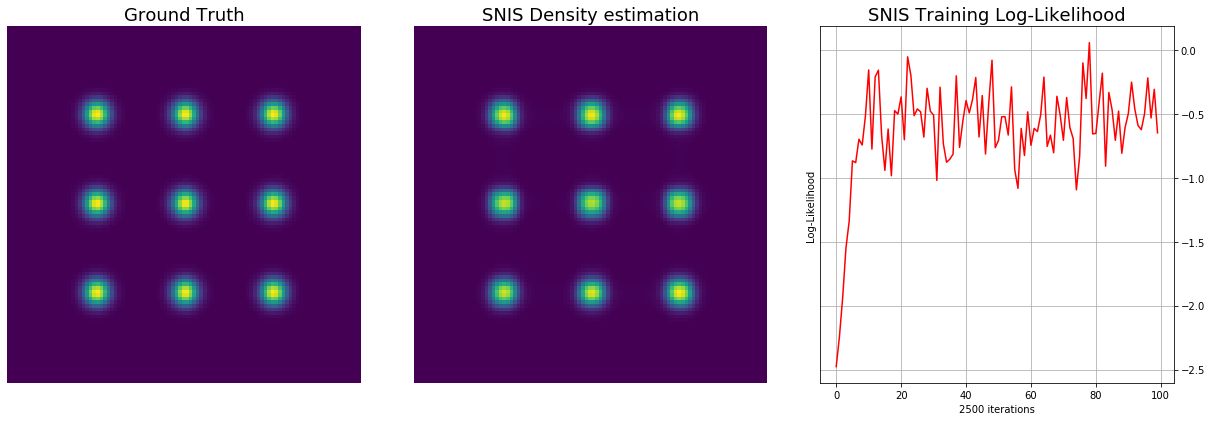

In [32]:
side = np.linspace(-2, 2, 100)
xs, ys = np.meshgrid(side, side)

points = np.vstack((xs.reshape([1, -1]), ys.reshape([1, -1])))
points = tf.transpose(tf.cast(points, tf.float32))

# Get ground truth plot
likelihoods = tf.reduce_prod(mixture.prob(points), axis=1).numpy()

# Get predicted plot
un_log_probs = tf.reduce_sum(sd.prior.log_prob(points), axis=1, keepdims=True) + sd.energy_fn(points)
log_Z = tf.reduce_logsumexp(un_log_probs)

log_probs = un_log_probs - log_Z

# Plot stuff
plt.figure(figsize=(18, 5.5))
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.15)

plt.subplot(131)
plt.title("Ground Truth", fontsize=18)
plt.pcolormesh(xs, ys, likelihoods.reshape(xs.shape))
plt.axis("off")

plt.subplot(132)
plt.title("SNIS Density estimation", fontsize=18)
plt.pcolormesh(xs, ys, tf.math.exp(log_probs).numpy().reshape(xs.shape))
plt.axis("off")

ax = plt.subplot(133)
plt.title("SNIS Training Log-Likelihood", fontsize=18)
plt.plot(log_liks, c='r')
plt.grid(True)
plt.xlabel("2500 iterations")
plt.ylabel("Log-Likelihood")
ax.yaxis.tick_right()

plt.show()